In [1]:
import gzip
from collections import Counter, defaultdict
from Bio import SeqIO
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

infos = pd.read_excel("../../1_analysis_of_rna_seq/RNAseq.xls")
infos = infos[~infos["Replicate"].isna()]
samples = list(infos["Sample"])

# Distribution of phred quality score

In [170]:
data = dict()
for sample in samples:
    counter = defaultdict(int)
    for r in ["R1", "R2"]:
        path = "../../1_analysis_of_rna_seq/data/datasets/%s_%s.fastq.gz" % (sample, r)
        with gzip.open(path, "rt") as f:
            for i, read in enumerate(SeqIO.parse(f, "fastq")):
                if i >= 10000:
                    break
                for quality in read._per_letter_annotations["phred_quality"]:
                    counter[quality] += 1
    data[sample] = counter

In [171]:
rows = []
for sample in samples:
    counter = data[sample]
    rows.append([counter[q] for q in np.arange(50)])
m = pd.DataFrame(rows)

q20_list = []
q30_list = []
for sample in samples:
    counter = data[sample]
    total = 0
    q20 = 0
    q30 = 0
    for k, v in counter.items():
        total += v
        if k >= 20:
            q20 += v
        if k >= 30:
            q30 += v
    q20_list.append(q20 * 100 / total)
    q30_list.append(q30 * 100 / total)
    
m1 = m.divide(m.sum(axis=1), axis=0) * 100

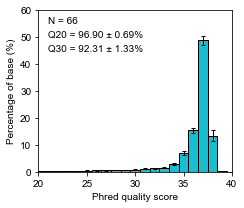

In [173]:
means = m1.mean()
stds = m1.std()
xs = np.array(means.index)

plt.figure(figsize=(3.5, 3))
plt.bar(xs, means, yerr=stds, width=1, edgecolor="black", color="C9", error_kw={"lw": 1, "capsize": 2})
plt.text(21, 55, "N = %d" % len(samples))
plt.text(21, 50, "Q20 = %.2f ± %.2f%%" % (np.mean(q20_list), np.std(q20_list)))
plt.text(21, 45, "Q30 = %.2f ± %.2f%%" % (np.mean(q30_list), np.std(q30_list)))
plt.xlim(20, 40)
plt.ylim(0, 60)
plt.xlabel("Phred quality score")
plt.ylabel("Percentage of base (%)")
plt.xticks(np.arange(20, 41, 5))
plt.tight_layout()
plt.savefig("figures/distribution_of_phred_quality_score.pdf", dpi=300)

# Phred quality score distribution at reads

In [2]:
data = dict()
for sample in samples:
    for r in ["R1", "R2"]:
        if r not in data:
            data[r] = []
        rows = data[r]
        path = "../../1_analysis_of_rna_seq/data/datasets/%s_%s.fastq.gz" % (sample, r)
        with gzip.open(path, "rt") as f:
            for i, read in enumerate(SeqIO.parse(f, "fastq")):
                if i >= 10000:
                    break
                qualities = np.array(read._per_letter_annotations["phred_quality"])
                rows.append(qualities)        

In [3]:
m1 = pd.DataFrame(data["R1"])
m2 = pd.DataFrame(data["R2"])

In [4]:
def get_quartile(values):
    vs = list(sorted(values))
    return vs[0], vs[int(len(vs) * 0.1)], vs[int(len(vs) * 0.5)], vs[int(len(vs) * 0.9)], vs[-1]

array = []
for m in [m1, m2]:
    ys = m.mean()
    xs = np.arange(len(ys))
    ys1 = []
    ys2 = []
    for c in m.columns:
        v1, v2, v3, v4, v5 = get_quartile(m[c])
        ys1.append(v2)
        ys2.append(v4)
    array.append([xs, ys, ys1, ys2])

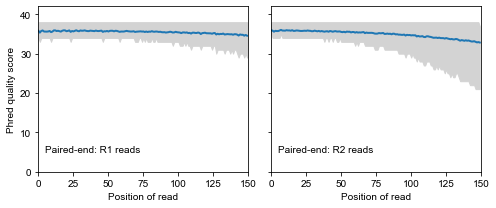

In [6]:
fig, axs = plt.subplots(1, 2, figsize=(7, 3), sharex=True, sharey=True)

for i in range(2):
    xs, ys, ys1, ys2 = array[i]
    
    ax = axs[i]
    plt.sca(ax)
    # plt.title("R%d" % (i + 1))
    plt.plot(xs, ys, lw=2, color="C0")
    plt.fill_between(xs, ys1, ys2, color="lightgrey")
    plt.text(5, 5, "Paired-end: R%d reads" % (i + 1))  
    plt.xlabel("Position of read")
    if i == 0:
        plt.ylabel("Phred quality score")
        
    plt.xlim(0, 150)
    plt.ylim(0, 42)

plt.tight_layout()
plt.savefig("figures/distribution_of_phred_quality_score_at_read.pdf", dpi=300)